# Application of the Nearest Advocate method for clock-drift correction on real event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors  

In [1]:
SYNC_PATH = "fig/clockdrift_correction"

# select files to analyse
PATH_HEART_RATE_DATA = "../data/HeartBeatData"

FILTER_LARGE_DIST = False  # filter too large distances between events
WINDOW_LENGTH = 40
SLIDING_LENGTH = 5
BANDWIDTH = 60
SPS_ADAPTATION_FACTOR = 0.995

# Config for Synchronize_file
MAX_N_WIN_SYNCS = 10
MAE_THRESHOLD = 1.0
MAX_TRIALS = 3
SYNCED_POSTFIX = ""  # ending of the synced file in SYNC_PATH

# search space, i.e., the intervall to search the time-delta in
TD_MAX = 200  # + 1.5 minutes
TD_MIN = -200
TD_MID = 25  # scope for medium granularity search
DIST_MAX = -1.0 
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate

SAMPLE_RATE_DT = 10
SPECTROSCOPY_XVAL_DT = 0.1  # Time steps for the spectroscopy representation

In [2]:
import os
import sys
import json
import time
from pprint import pprint
from datetime import datetime
import pytz

import math
import numpy as np
np.random.seed(1)

from numba import jit, njit, prange

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy import stats
import sklearn.metrics
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import HuberRegressor, LinearRegression


import seaborn as sns
sns.set(style='whitegrid')  # "white"
#sns.set_theme(style="ticks")
sns.set_context('notebook')

In [3]:
# loading own packages
from utils import moving_aggregation, moving_aggregation_nb
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

## Load files

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
arr_ref, arr_sig = heart_beat_dataset[0]

In [6]:
ref_median_diff = np.median(np.diff(arr_ref))
print(f"Array Ref, min: {np.min(np.diff(arr_ref)):.4f}, median: {np.median(np.diff(arr_ref)):.4f}, max: {np.max(np.diff(arr_ref)):.4f}")
print(f"Array Sig, min: {np.min(np.diff(arr_sig)):.4f}, median: {np.median(np.diff(arr_sig)):.4f}, max: {np.max(np.diff(arr_sig)):.4f}")

Array Ref, min: 0.5260, median: 1.0160, max: 10.2840
Array Sig, min: 0.6362, median: 1.0319, max: 5.3246


(0.0, 2.0)

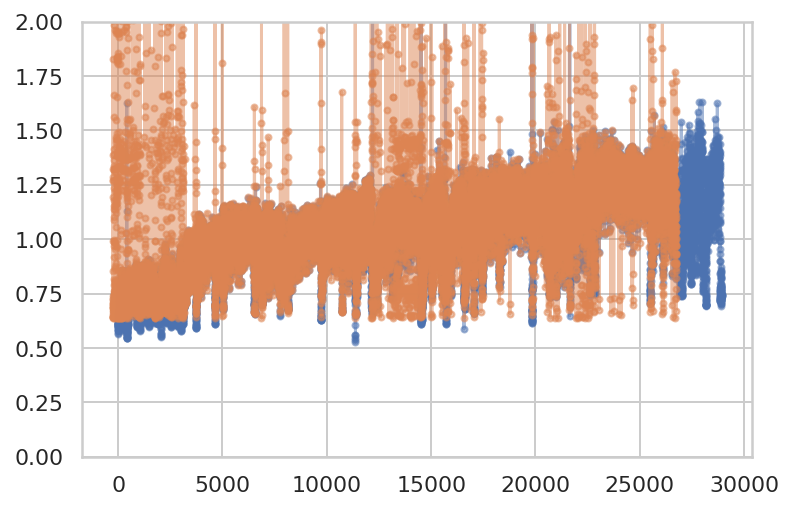

In [7]:
plt.plot(arr_ref[:-1], np.diff(arr_ref), alpha=0.5, marker=".")
plt.plot(arr_sig[:-1], np.diff(arr_sig), alpha=0.5, marker=".")
plt.xlim(None, None)
plt.ylim(0, 2)

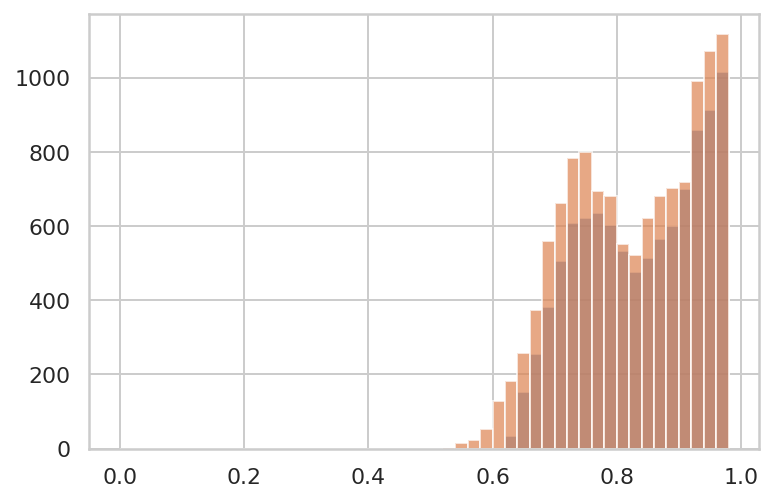

In [8]:
bins=np.arange(0,1,0.02)
plt.hist(np.diff(arr_sig), bins=bins, alpha=0.7);
plt.hist(np.diff(arr_ref), bins=bins, alpha=0.7);
# plt.xlim(0, 2)

(0.0, 2.0)

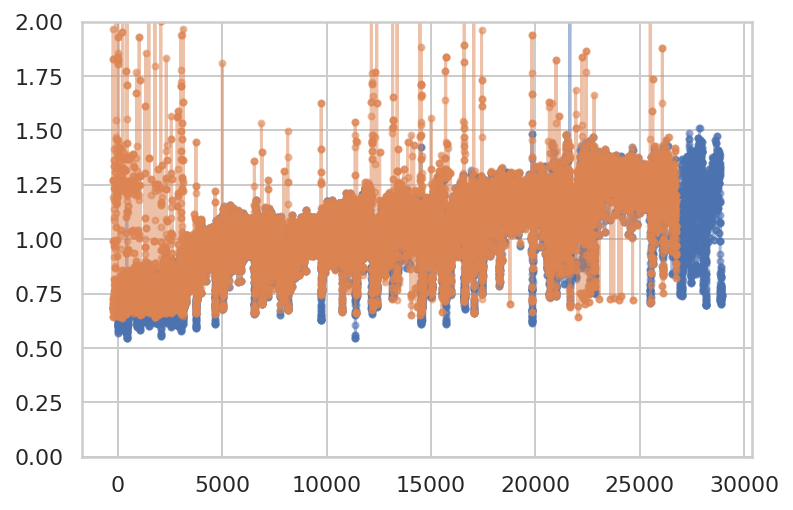

In [9]:
plt.plot(arr_ref[1:], moving_aggregation(np.diff(arr_ref), w=3, aggregation="median"), alpha=0.5, marker=".")
plt.plot(arr_sig[1:], moving_aggregation(np.diff(arr_sig), w=3, aggregation="median"), alpha=0.5, marker=".")
# plt.xlim(3700, 4100)
plt.ylim(0, 2)

In [10]:
# arr_ref = arr_ref.min() + moving_aggregation(np.diff(arr_ref), w=4, aggregation="median").cumsum()
# arr_sig = arr_sig.min() + moving_aggregation(np.diff(arr_sig), w=4, aggregation="median").cumsum()

In [11]:
arr_ref[:10], arr_ref.max(), arr_sig[:10], arr_sig.max()

(array([1.15 , 1.79 , 2.406, 3.006, 3.602, 4.206, 4.81 , 5.414, 6.008,
        6.592]),
 28919.912,
 array([-249.40776605, -246.11179557, -245.47063414, -244.79941827,
        -242.73067084, -242.03941867, -241.30308484, -240.57676915,
        -239.89553513, -239.23934648]),
 26753.065838917577)

In [12]:
td = 50
for i in range(0, 200, 10):
    arr = (arr_sig[i]-arr_sig[0]) * (1-0.0) + arr_sig[0]
    print(f"{i:2d}, {arr_ref[i]:.5f}, {arr:.5f}, {arr-arr_ref[i]:.5f}")

 0, 1.15000, -249.40777, -250.55777
10, 7.16800, -238.53808, -245.70608
20, 13.11200, -225.26403, -238.37603
30, 19.46400, -216.61336, -236.07736
40, 25.90000, -209.04966, -234.94966
50, 32.28600, -201.53104, -233.81704
60, 39.19200, -192.03384, -231.22584
70, 46.27200, -180.37772, -226.64972
80, 52.97800, -170.92560, -223.90360
90, 59.75200, -163.15653, -222.90853
100, 66.92600, -153.39384, -220.31984
110, 74.18600, -142.58927, -216.77527
120, 81.28400, -134.86027, -216.14427
130, 88.42000, -125.16270, -213.58270
140, 95.47600, -114.93918, -210.41518
150, 101.83800, -107.14506, -208.98306
160, 108.04400, -99.58136, -207.62536
170, 114.83600, -86.76314, -201.59914
180, 122.00000, -74.89164, -196.89164
190, 129.03400, -62.10848, -191.14248


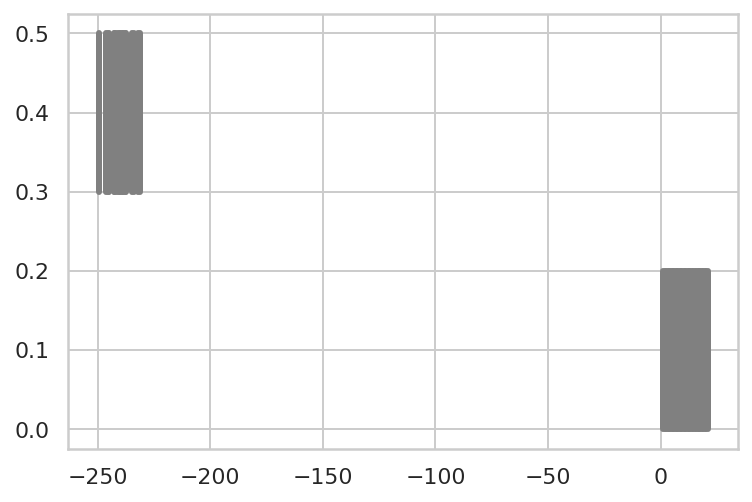

In [13]:
max_t = 20
arr1 = arr_ref[arr_ref < (arr_ref.min()+max_t)]
arr2 = arr_sig[arr_sig < (arr_sig.min()+max_t)]

for idx, event in enumerate(arr1):
    plt.plot([event]*10, np.linspace(0, 0.2, 10), color="gray", lw=3)
    
for idx, event in enumerate(arr2):
    plt.plot([event]*10, np.linspace(0.3, 0.5, 10), color="grey", lw=3)


## Load and test functions

Found optimum for a time shift of -1.020s in 1.993s


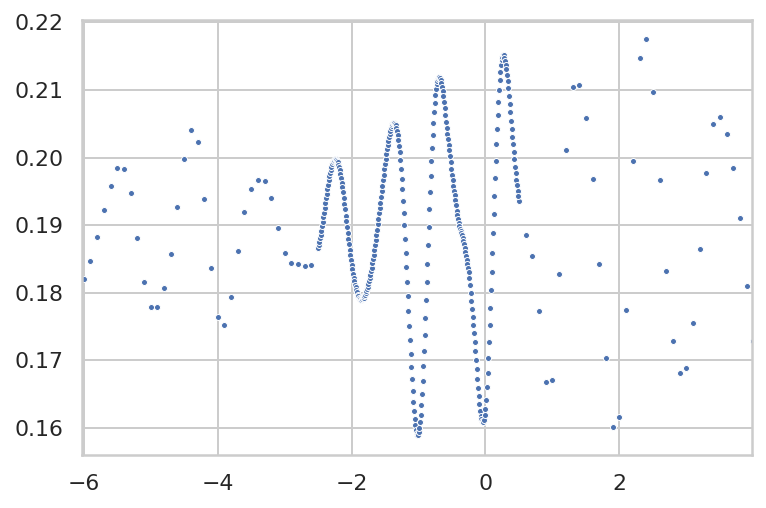

In [14]:
import numpy as np
from numba import njit


@njit(parallel=False)
def nearest_advocate_single(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                            dist_max: float, dist_padding: float, regulate_paddings: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    regulate_paddings (bool): Regulate non-overlapping events in arr_sig with a maximum distance of err_max, default True
    dist_padding (float): Distance assigned to non-overlapping (padding) events, should be 1/4 of the median gap of arr_ref. Only given if regulate_paddings is True
    '''
    # Assert input properties
    assert arr_ref.shape[0] > 0    # reference array must be non-empty
    assert arr_sig.shape[0] > 0    # signal array must be non-empty
    assert dist_max > 0.0          # maximal distance must be greater than 0.0
    if regulate_paddings:
        assert dist_padding > 0.0  # maximal distance for paddings must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
            
    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    counter = 0              # number of advocate events
    cum_distance = 0.0       # cumulative distances between advocate events
    
    # Step 1: cut leading reference timestamps without finding advocates
    while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1
        
    # return dist_max, if arr_ref ends before arr_sig starts
    if ref_idx+1 == l_arr_ref:
        return dist_max
    
    # Case: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
    assert arr_ref[ref_idx+1] > arr_sig[sig_idx]
    
    # Step 2: count leading signal timestamps with finding advocates
    while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
        # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
        if regulate_paddings:
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_padding)
            counter += 1
        sig_idx += 1
        
    # return dist_max, if arr_sig ends before arr_ref starts
    if sig_idx == l_arr_sig:
        return dist_max     
    
    # Step 3 (regular case) and step 4 (match trailing signal timestamps)
    while sig_idx < l_arr_sig:
        # Step 3: regular case
        if arr_sig[sig_idx] < arr_ref[-1]:
            # forward arr_ref and then arr_sig until regalar case
            while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx+1 >= l_arr_ref: 
                sig_idx += 1
                continue
            # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
            # assert arr_ref[ref_idx] <= arr_sig[sig_idx]
            # assert arr_sig[sig_idx] < arr_ref[ref_idx+1]
            
            cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max) 
            counter += 1
        # Step 4: match trailing reference timestamps with last signal timestamp
        elif regulate_paddings:  
            # Invariant: arr_ref[ref_idx+1] <= arr_sig[sig_idx], given by the else case
            if arr_sig[sig_idx]-arr_ref[ref_idx+1] < dist_padding:
                cum_distance += arr_sig[sig_idx]-arr_ref[ref_idx+1]
                counter += 1
            else: 
                # case with only dist_padding increments from now on
                cum_distance += (l_arr_sig - sig_idx) * dist_padding
                counter += (l_arr_sig - sig_idx)
                break # stop, because the last values can be aggregated
                
        sig_idx += 1
    
    # return mean cumulative distance between found advocate events
    return cum_distance / counter


@njit(parallel=False)
def nearest_advocate(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                     td_min: float, td_max: float, td_prox=None, sps: float=10, sparse_factor: int=1, 
                     dist_max: float=0.0, regulate_paddings: bool=True, dist_padding: float=0.0,
                    finesearch: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps for a search space between td_min and td_max with a precision of 1/sps. The synchronicity is given by the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    td_min (float): lower bound of the search space for the time-shift
    td_max (float): upper bound of the search space for the time-shift
    sps (int): number of investigated time-shifts per second, should be higher than 10 times the number of median gap of arr_ref (default 10).
    sparse_factor (int): factor for the sparseness of arr_sig for the calculation, higher is faster but may be less accurate (default 1)
    dist_max (None, float): Maximal accepted distances, default None: 1/4 of the median gap of arr_ref
    dist_padding (None, float): Assumed distances of non-overlapping (padding) matches, default None: 1/4 of the median gap of arr_ref
    regulate_paddings (bool): regulate non-overlapping events in arr_sig with a maximum distance of err_max
    '''
    # set the default values for dist_max, dist_padding relative if not set
    # TODO improve default value: min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
    if dist_max <= 0.0:
        dist_max = np.median(np.diff(arr_ref))/4
    if dist_padding <= 0.0:
        dist_padding = np.median(np.diff(arr_ref))/4
    if td_prox is None:
        td_prox = 1.5 * np.median(np.diff(arr_ref))
        
    # Random subsample and create a copy of arr_sig once, as it could lead to problems otherwise
    if sparse_factor > 1:
        probe = arr_sig[sparse_factor//2::sparse_factor].copy()
    else:
        probe = arr_sig.copy()
    
    # Create an k x 2 matrix to store the investigated time-shifts and their respective mean distance
    broad_search_n_samples = int((td_max-td_min)*sps)
    fine_search_n_samples = int(2*10*td_prox*sps)   # fine search with factor 1/10 sampling
    
    if finesearch:
        time_delays = np.empty((broad_search_n_samples+fine_search_n_samples, 2), dtype=np.float32)
        time_delays[:broad_search_n_samples, 0] = np.arange(td_min, td_max, 1/sps) #[:broad_search_n_samples]
    else:
        time_delays = np.empty((broad_search_n_samples, 2), dtype=np.float32)
        time_delays[:, 0] = np.arange(td_min, td_max, 1/sps)[:broad_search_n_samples]
        
    # Calculate the mean distance for all time-shifts in the search space. 
    # The shift with the lowest mean distance is the best fit for the time-shift
    idx = 0
    while idx < broad_search_n_samples:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1
    
    if not finesearch:
        return time_delays
    
    # finesearch around the peak
    time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:broad_search_n_samples,1])]
    time_delays[broad_search_n_samples:, 0] = np.arange(time_shift-td_prox, time_shift+td_prox-1e-12, 
                                                        1/sps/10)[:fine_search_n_samples]
    while idx < time_delays.shape[0]:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1     
    return time_delays

# run once before the test to just-in-time compile it
start_time = time.time()
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=-10, td_max=10, td_prox=1.5, sps=SAMPLE_RATE_DT, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX,
                              finesearch=True)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

In [15]:
#%%timeit
#_ = nearest_advocate(ts_ref, ts_sig, time_delta=0.0, err_max=0.4)

In [16]:
np_nearest = nearest_advocate(arr_ref, arr_sig[100:1000].astype(np.float32), 
                              td_min=-100, td_max=100, 
                              sparse_factor=1, sps=SAMPLE_RATE_DT, 
                              dist_max=-1, regulate_paddings=True, dist_padding=-1)
df_nearest = pd.DataFrame(np_nearest, columns=["time-delta", "distance"])
df_nearest.head(5)

,time-delta,distance
0,-100.000000,0.169026
1,-99.900002,0.170661
2,-99.800003,0.171559
3,-99.699997,0.169787
4,-99.599998,0.168337


In [17]:
N = 10_000 
arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=N))).astype(np.float32)
arr_sig = np.sort(arr_ref + np.pi + np.random.normal(loc=0, scale=0.1, size=N)).astype(np.float32)

In [18]:
time_shifts = nearest_advocate(arr_ref, arr_sig, 
                               td_min=-60, td_max=60, sps=20)
time_shift, min_mean_dist = time_shifts[np.argmin(time_shifts[:,1])]

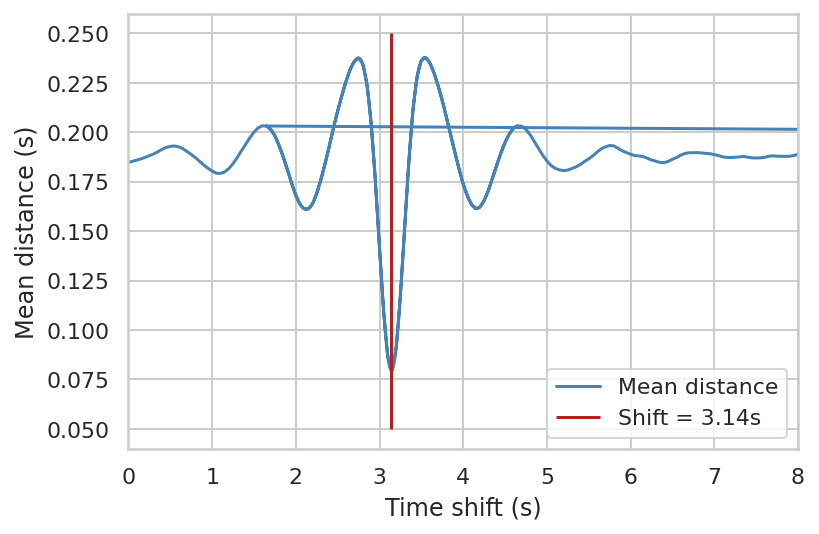

In [19]:
plt.plot(time_shifts[:,0], time_shifts[:,1], color="steelblue", label="Mean distance")
plt.vlines(x=time_shift, ymin=0.05, ymax=0.25, color="firebrick", label=f"Shift = {time_shift:.2f}s")
plt.xlim(0, 8)
plt.xlabel("Time shift (s)")
plt.ylabel("Mean distance (s)")
plt.legend(loc="lower right")
plt.show()

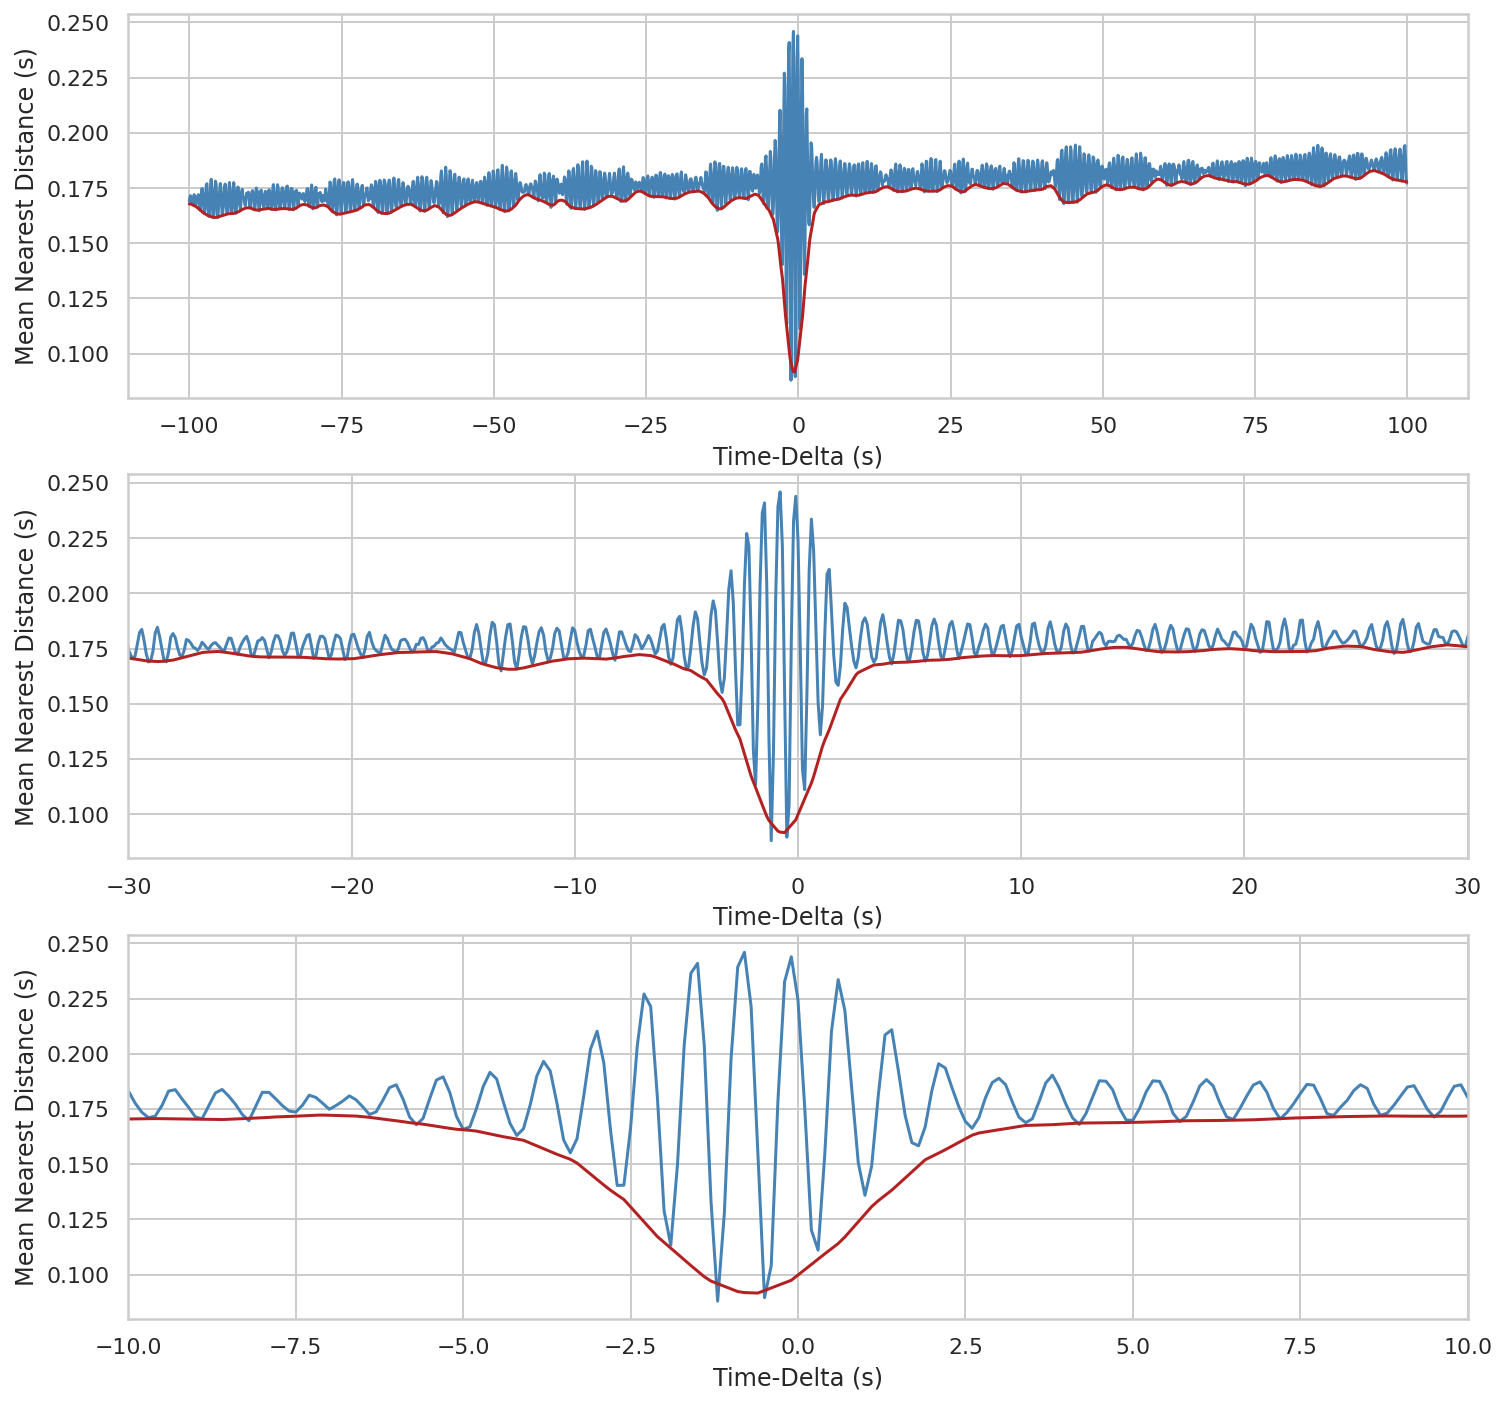

In [20]:
fig, axes = plt.subplots(3,1, figsize=(12, 12))

df_ = df_nearest.loc[:int((df_nearest["time-delta"].max()-df_nearest["time-delta"].min())*SAMPLE_RATE_DT)]
n_kernels = int(1*SAMPLE_RATE_DT * np.median(np.diff(arr_ref)))
for ax in axes:
    sns.lineplot(data=df_, x="time-delta", y="distance", color="steelblue", ax=ax)
    sns.lineplot(x=df_["time-delta"], 
                 y=moving_aggregation(moving_aggregation(df_["distance"].values, w=n_kernels, aggregation="min"), w=2*n_kernels, aggregation="mean"), 
                 color="firebrick", ax=ax)
    ax.set_xlabel("Time-Delta (s)")
    ax.set_ylabel("Mean Nearest Distance (s)")
    
axes[1].set_xlim(-30, 30)
axes[2].set_xlim(-10, 10)
plt.show()

## Frequency analysis of the result

Seems to be not important.

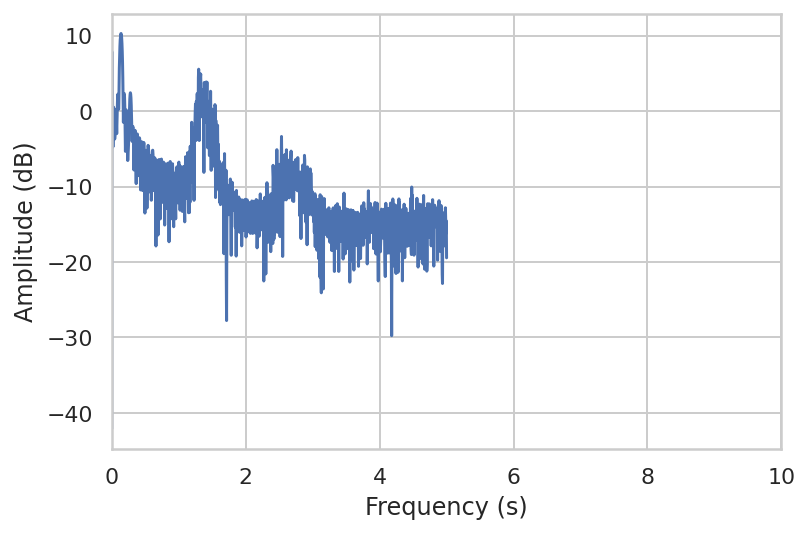

In [21]:
from scipy.fft import rfft, rfftfreq

df = df_nearest[df_nearest["distance"] < ref_median_diff / 2]
yf = rfft(np.array(df["distance"] - df["distance"].mean()))
xf = rfftfreq(len(df), 1 / SAMPLE_RATE_DT)

plt.plot(xf, 10*np.log10(np.abs(yf)))
plt.xlabel("Frequency (s)")
plt.ylabel("Amplitude (dB)")
plt.xlim(0, 10)
plt.show()

## Window-wise sync

In [22]:
@njit
def numba_diff(x):
    return x[1:] - x[:-1]

@jit(nopython=True)
def interp_nb(x_vals, x, y):
    return np.interp(x_vals, x, y)

@njit(parallel=True)
def window_sync_parallel(arr_ref, arr_sig, td_min=-60, td_max=60, td_mid=30, sparse_factor=1, 
                dist_max=None, regulate_paddings=True, dist_padding=None, 
                window_len=50, sliding_len=25, sps=SAMPLE_RATE_DT):
    # make a copy because it is more robust for numba jit-compiled functions
    arr_ref = arr_ref.copy()
    arr_sig = arr_sig.copy()
        
    # define window centers and init df_results
    window_centers = np.arange(0, arr_ref.max()-arr_ref.min(), sliding_len)
    res_len = len(window_centers)
    # create randomly sized time windows for each center windows, sampled from a log-normal distribution
    window_len_samples = window_len * np.exp(np.random.normal(loc=1, scale=1, size=res_len))

    dict_results = {"index": np.nan*np.zeros(res_len, dtype=np.int32),
                    "timestamp": np.nan*np.zeros(res_len, dtype=np.float32),
                    "time-delta": np.nan*np.zeros(res_len, dtype=np.float32),
                    "min-distance": np.nan*np.zeros(res_len, dtype=np.float32),
                    "min-distance-away": np.nan*np.zeros(res_len, dtype=np.float32),
                    "min-distance-difference": np.nan*np.zeros(res_len, dtype=np.float32)}
    
    # Iterate over all window_centers for multiple estimates
    min_err = 1e9
    max_delta = 0.0
    min_err_windows_ts = None
    n_kernels = int(2 * SAMPLE_RATE_DT * np.median(numba_diff(arr_ref)) + 1)
    spectrogram_interp_xvals = np.arange(td_min, td_max, SPECTROSCOPY_XVAL_DT).astype(np.float32)
    spectrogram = np.nan * np.ones((len(window_centers), len(spectrogram_interp_xvals)), dtype=np.float32)
    # numba parallel loop
    for idx in prange(res_len):
        arr_sig_window = arr_sig[np.logical_and(arr_sig.min()+window_centers[idx]-window_len_samples[idx]/2 <= arr_sig, 
                                                arr_sig < arr_sig.min()+window_centers[idx]+window_len_samples[idx]/2)]
        if len(arr_sig_window) <= 5:
            continue
        nearest_results = nearest_advocate(arr_ref, arr_sig_window,
                                           td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=sps, 
                                           dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        nearest_tds, nearest_distances = nearest_results[:,0], nearest_results[:,1]

        # calculate statistics
        td_hat = nearest_tds[np.argmin(nearest_distances)]       # time-delta with the minimal distance
        away_idx = np.abs(nearest_tds-td_hat) > td_mid           # indices of time-deltas more than td_mid away from the found minimum
        min_distance_window = np.min(nearest_distances)                 # minimal distance of all time-deltas
        min_distance_window_away = np.min(nearest_distances[away_idx])  # minimal distance of all time-deltas more than td_mid away from the minimum

        # document the results in the dict_result
        dict_results["index"][idx] = idx
        dict_results["timestamp"][idx] = window_centers[idx]
        dict_results["time-delta"][idx] = td_hat
        dict_results["min-distance"][idx] = min_distance_window
        dict_results["min-distance-away"][idx] = min_distance_window_away
        dict_results["min-distance-difference"][idx] = min_distance_window_away - min_distance_window
        
        # store the information in the spectrogram
        spectrogram[idx, :] = interp_nb(spectrogram_interp_xvals, nearest_tds, 
                                        moving_aggregation_nb(
                                            moving_aggregation_nb(nearest_distances, w=n_kernels, aggregation="min"), 
                                            w=2*n_kernels, aggregation="mean").copy())

    return dict_results, spectrogram

# test window_sync_parallel
dict_results, spectrogram = window_sync_parallel(
    arr_ref=arr_ref, arr_sig=arr_sig,
    td_min=TD_MIN, td_max=TD_MAX, sparse_factor=1, 
    dist_max=-1, regulate_paddings=True, dist_padding=-1, 
    window_len=50, sliding_len=200, sps=SAMPLE_RATE_DT)
pd.DataFrame({k: v for k, v in dict_results.items()}).head()

,index,timestamp,time-delta,min-distance,min-distance-away,min-distance-difference
0,0.0,0.0,3.136887,0.072792,0.164767,0.091975
1,1.0,200.0,3.146887,0.078883,0.172618,0.093735
2,2.0,400.0,3.146887,0.079983,0.173692,0.093708
3,3.0,600.0,3.126887,0.068280,0.149050,0.080770
4,4.0,800.0,3.146887,0.081059,0.171228,0.090169


In [23]:
# %%timeit
# _ = window_sync_parallel(
#     arr_ref=arr_ref,
#     arr_sig=arr_sig,
#     td_min=TD_MIN, td_max=TD_MAX, sparse_factor=1, 
#     dist_max=None, regulate_paddings=True, dist_padding=None, 
#     window_len=50, sliding_len=20, sps=SAMPLE_RATE_DT)
# # normal=4s, njit=3.9s, njit(parallel=True)=3.9s, njit(parallel=True),prange=0.213s

In [24]:
def window_sync(file_ref, file_sig, td_min=-60, td_max=60, td_mid=30, sparse_factor=1, 
                dist_max=-1, regulate_paddings=True, dist_padding=-1, 
                window_len=50, sliding_len=25, bandwidth=30, sps_adaption_factor=1, sps=SAMPLE_RATE_DT, 
                parallelize=False, verbose=0, save_fig=None):    
    # load arrays, make a copy because it is more robust for numba jit-compiled functions
    if isinstance(file_ref, str):
        arr_ref = load_file(filename=file_ref, sps_adaption_factor=1.0, 
                            filter_large_dist=FILTER_LARGE_DIST).copy()  # reference has always sps_adaption_factor=1.0
    else:
        arr_ref = file_ref.copy()
    
    if isinstance(file_sig, str):
        arr_sig = load_file(filename=file_sig, sps_adaption_factor=sps_adaption_factor, filter_large_dist=FILTER_LARGE_DIST).copy()   
    else:
        arr_sig = file_sig.copy()
    
    # parallelize in numby
    if parallelize:
        dict_results, spectrogram = window_sync_parallel(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=td_min, td_max=td_max, td_mid=td_mid, sparse_factor=sparse_factor, sps=sps,
            dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding,
            window_len=window_len, sliding_len=sliding_len)
    else:        
        # define window centers and init df_results
        window_centers = np.arange(0, arr_ref.max()-arr_ref.min(), sliding_len)
        res_len = len(window_centers)
        print(f"Starting the window-wise synchronization with {res_len} windows, window_len: {window_len}, sliding_len: {sliding_len}")

        dict_results = {"index": np.nan*np.zeros(res_len, dtype=np.int32),
                        "timestamp": np.nan*np.zeros(res_len, dtype=np.float32),
                        "time-delta": np.nan*np.zeros(res_len, dtype=np.float32),
                        "min-distance": np.nan*np.zeros(res_len, dtype=np.float32),
                        "min-distance-away": np.nan*np.zeros(res_len, dtype=np.float32),
                        "min-distance-difference": np.nan*np.zeros(res_len, dtype=np.float32)}

        # Iterate over all window_centers for multiple estimates
        min_err = 1e9
        max_delta = 0.0
        min_err_windows_ts = None
        n_kernels = int(2 * SAMPLE_RATE_DT * np.median(numba_diff(arr_ref)) + 1)
        spectrogram_interp_xvals = np.arange(td_min, td_max, SPECTROSCOPY_XVAL_DT).astype(np.float32)
        spectrogram = np.nan * np.ones((len(window_centers), len(spectrogram_interp_xvals)), dtype=np.float32)
        for idx, window_center in enumerate(window_centers):
            # arr_ref_window = arr_ref
            window_len_sample = window_len * np.exp(np.random.normal(loc=1, scale=1, size=1)[0])
            # if window_center-window_len_sample/2 < 0 or window_center+window_len_sample/2 > arr_sig.max()-arr_sig.min():
            #     continue
            arr_sig_window = arr_sig[np.logical_and(arr_sig.min()+window_center-window_len_sample/2 <= arr_sig, 
                                                   arr_sig < arr_sig.min()+window_center+window_len_sample/2)]
            if len(arr_sig_window) <= 5:
                continue
            # find nearest-advocates in the windows
            nearest_results = nearest_advocate(arr_ref, arr_sig_window,
                                         td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=sps, 
                                         dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
            nearest_tds, nearest_distances = nearest_results[:,0], nearest_results[:,1]

            # calculate statistics
            td_hat = nearest_tds[np.argmin(nearest_distances)]       # time-delta with the minimal distance
            away_idx = np.abs(nearest_tds-td_hat) > td_mid           # indices of time-deltas more than td_mid away from the found minimum
            min_distance_window = np.min(nearest_distances)                 # minimal distance of all time-deltas
            min_distance_window_away = np.min(nearest_distances[away_idx])  # minimal distance of all time-deltas more than td_mid away from the minimum

            # document the results in the dict_result
            dict_results["index"][idx] = idx
            dict_results["timestamp"][idx] = window_centers[idx]
            dict_results["time-delta"][idx] = td_hat
            dict_results["min-distance"][idx] = min_distance_window
            dict_results["min-distance-away"][idx] = min_distance_window_away
            dict_results["min-distance-difference"][idx] = min_distance_window_away - min_distance_window
            
            # check how well it is globally
            if td_hat != TD_MIN and min_distance_window_away - min_distance_window > max_delta:
                max_delta = min_distance_window_away - min_distance_window
                # min_distance_windows_ts = window_center
                postfix1 = "*"
            else:
                postfix1 = ""
            if td_hat != TD_MIN and min_distance_window < min_err:
                min_err = min_distance_window
        #         min_err_slice_idx = slice_idx_start
                postfix2 = "+"
            else:
                postfix2 = ""

            spectrogram[idx, :] = np.interp(spectrogram_interp_xvals, nearest_tds,
                                            moving_aggregation(
                                                moving_aggregation(nearest_distances, w=n_kernels, aggregation="min"), 
                                                w=2*n_kernels, aggregation="mean"))

            if verbose >= 2:
                print(f"  Window {idx:3d} at: ({window_center:.1f}s +- {window_len_sample/2:.2f}s),\t", end="")
                print(f"Minimum at {td_hat:.3f}s,\t score: {min_distance_window:.6f} ", end="")
                print(f"others: {min_distance_window_away:.6f}, \tdiff: {min_distance_window_away-min_distance_window:.6f} " + postfix1 + postfix2)

    # aggregate the results
    df_results = pd.DataFrame({k: v for k, v in dict_results.items()})
    min_distance_diff_window_ts = dict_results["timestamp"][np.argmax(dict_results["min-distance-difference"])]
    
    ## Filter the results and perform a robust linear regression
    # filter time-deltas with td_min     
    df_results.dropna(inplace=True)   
    df_results = df_results[df_results["time-delta"] != td_min]
    
    # find nearest-advocates in the best windows to get the results    
    arr_ref_window = arr_ref
    arr_sig_window = arr_sig # [np.logical_and(min_distance_diff_window_ts - window_len <= arr_sig, arr_sig < min_distance_diff_window_ts + window_len)]
    df_nearest = pd.DataFrame(
        nearest_advocate(arr_ref_window, arr_sig_window,
                                 td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, sps=sps, 
                                 dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding),
        columns=["time-delta", "distance"])
    td_hat = df_nearest.loc[np.argmin(df_nearest["distance"])]["time-delta"]
    df_away = df_nearest.loc[np.abs(df_nearest["time-delta"]-td_hat) > td_mid]
    
    # estimattion of a more acurate sps and time-delta    
    # filter on internal criterion measure
    df_results_filt = df_results[df_results["min-distance-difference"] >= df_results["min-distance-difference"].quantile(0.25)]
    df_results_filt = df_results_filt[df_results_filt["time-delta"] <= np.median(df_results_filt["time-delta"])+bandwidth]
    df_results_filt = df_results_filt[df_results_filt["time-delta"] >= np.median(df_results_filt["time-delta"])-bandwidth]
        
    # filter on KDE cluster criterion
    kde = KernelDensity(kernel='cosine', bandwidth=bandwidth).fit(df_results[["time-delta"]].values)
    time_deltas = np.linspace(td_min, td_max, td_max-td_min+1).reshape(-1, 1)
    kde_opt = time_deltas[np.argmax(kde.score_samples(time_deltas))][0]
    df_results_filt = df_results_filt.loc[(kde_opt-bandwidth < df_results_filt["time-delta"]) & (df_results_filt["time-delta"] < kde_opt+bandwidth)]
    
    # perform a robust linear regression
    model = sklearn.linear_model.TheilSenRegressor(random_state=1)  # HuberRegressor(fit_intercept=True)
    # TODO check if df_results_filt works better here
    model.fit(X=df_results_filt[["timestamp"]].values, y=df_results_filt["time-delta"].values)
    n_pred_points = 101; x = np.linspace(0, df_results["timestamp"].values[-1], n_pred_points) 
    pred_y = model.predict(x.reshape(-1,1))
    
    # calculate the stats of the linear model
    corr_coef = np.corrcoef(df_results["time-delta"].values, model.predict(df_results[["timestamp"]].values))[0,1]
    R_sq = corr_coef**2
    rmse = np.sqrt(np.mean((df_results["time-delta"].values - model.predict(df_results[["timestamp"]].values))**2))
    mae = np.mean(np.abs(df_results["time-delta"].values - model.predict(df_results[["timestamp"]].values)))
    if verbose >= 2:
        print(f"The coefficient of determination R²={R_sq:.4f}, the RMSE={rmse:.6f}, the MAE={mae:.6f}")
    
    # estimate the time-delta and sps
    td_hat = pred_y[0]
    td_hat_median = np.median(pred_y)
    sps_adaption_factor = sps_adaption_factor - sps_adaption_factor * model.coef_[0]
    if verbose >= 2:
        print(f"The optimal time-delta is at {td_hat:.3f} s and the sample rate factor at {sps_adaption_factor:.3f}")
        
    # Plot the result
    if verbose >= 1.0 or save_fig:
        plt.cla()
        # df_results["diff-rank"] = df_results["diff-err"].rank()
        sns.scatterplot(data=df_results, x="timestamp", y="time-delta", color="steelblue", label="Time-Delay", marker="o")
        # sns.scatterplot(data=df_results_filt, x="timestamp", y="time-delta", color="limegreen", label="Time-Delta robust")
        sns.lineplot(x=x, y=pred_y, color="darkorange", label="Robust Linear Fit")
        plt.xlabel("Window time (s)")
        plt.ylabel("Estimated Time-Delays (s)")
        td_mean = np.median(df_results["time-delta"])
        td_iqr = np.quantile(df_results["time-delta"], 0.75) - np.quantile(df_results["time-delta"], 0.25)
        plt.ylim(max(td_min, td_mean-2*td_iqr-1), min(td_max, td_mean+2*td_iqr+1))
        if save_fig:
            plt.savefig(save_fig)
        if verbose >= 1.5:
            plt.show()

    print()
    return sps_adaption_factor, td_hat, td_hat_median, df_results, spectrogram, rmse, mae

In [25]:
arr_ref, arr_sig = heart_beat_dataset[0]
# set a linear clock-drift
arr_sig = arr_sig / 0.9934 - 23.4

The coefficient of determination R²=0.0834, the RMSE=101.527487, the MAE=63.838715
The optimal time-delta is at -19.788 s and the sample rate factor at 0.994


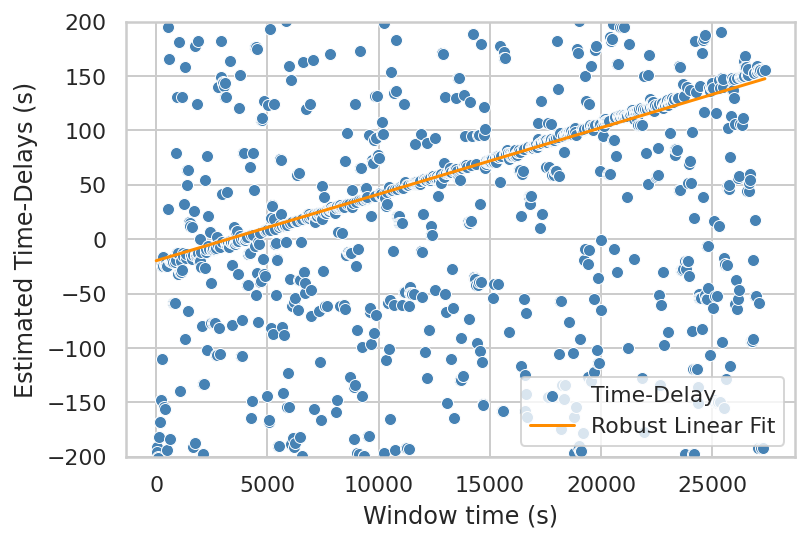

(0.9938857178215889,
 -19.787723052825072,
 63.90151426417741,
 101.52748715949099,
 63.83871515133735)

In [26]:
sps_adaption_factor, td_hat, td_hat_median, df_results, spectrogram, rmse, mae = window_sync(
    file_ref=arr_ref,
    file_sig=arr_sig,
    td_min=TD_MIN, td_max=TD_MAX, sparse_factor=1, 
    dist_max=DIST_MAX, regulate_paddings=True, dist_padding=DIST_MAX, 
    window_len=WINDOW_LENGTH, sliding_len=25, bandwidth=BANDWIDTH, sps=SAMPLE_RATE_DT,
    sps_adaption_factor=1.0, verbose=2, parallelize=True, # running parallel does not support high verbose mode
    save_fig="fig/clockdriftcorrection_round-1.png")
sps_adaption_factor, td_hat, td_hat_median, rmse, mae

In [27]:
df_results.head()

,index,timestamp,time-delta,min-distance,min-distance-away,min-distance-difference
1,1.0,25.0,-190.914001,0.181841,0.186412,0.004570
2,2.0,50.0,-196.014008,0.182906,0.187093,0.004187
3,3.0,75.0,-200.694000,0.173335,0.254000,0.080665
4,4.0,100.0,-200.964005,0.177858,0.189186,0.011328
5,5.0,125.0,-181.714005,0.085942,0.181476,0.095534


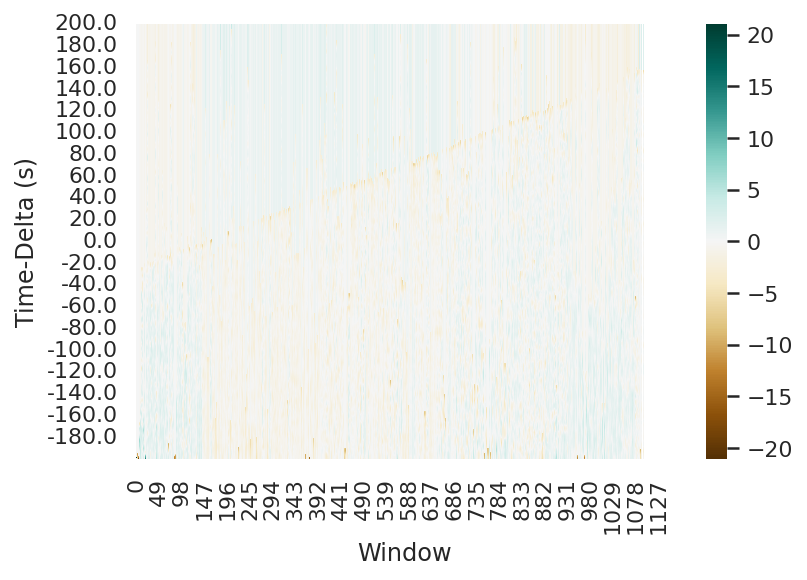

In [28]:
spectrogram_df = pd.DataFrame(spectrogram.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/spectrogram.shape[1])).iloc[::-1]
spectrogram_df = spectrogram_df[~spectrogram_df.isnull()]
spectrogram_df_normed = spectrogram_df.apply(lambda x: (x-spectrogram_df.mean(axis=0))/spectrogram_df.std(axis=0), axis=1)

ax = sns.heatmap(spectrogram_df_normed, linewidth=0.0, cmap="BrBG")
ax.set_xlabel("Window")
ax.set_ylabel("Time-Delta (s)")
n_yticks = 10; ax.set_yticks(np.arange(0, len(spectrogram_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

plt.show()

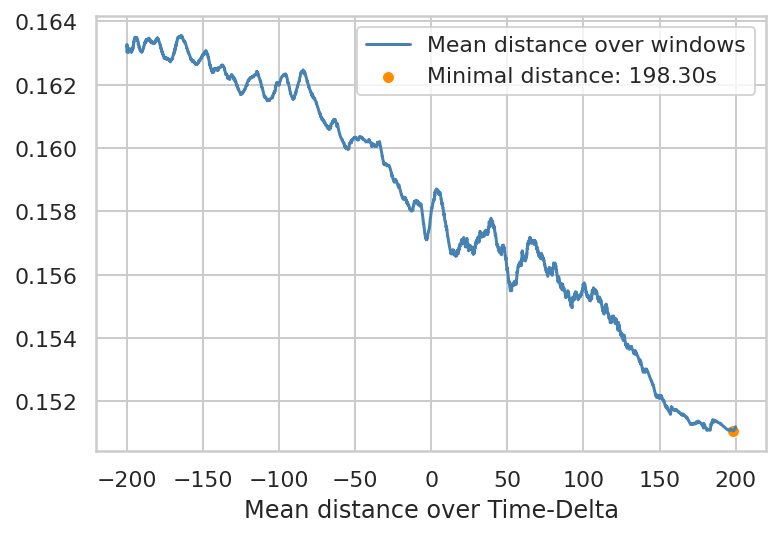

In [29]:
spectrogram_mean_df = spectrogram_df[spectrogram_df < spectrogram_df.max()].mean(axis=1)

sns.lineplot(data=spectrogram_mean_df,color="steelblue", label="Mean distance over windows")
sns.scatterplot(x=[spectrogram_mean_df.index[spectrogram_mean_df.argmin()]], y=[spectrogram_mean_df.iloc[spectrogram_mean_df.argmin()]], 
                color="darkorange", label=f"Minimal distance: {spectrogram_mean_df.index[spectrogram_mean_df.argmin()]:.2f}s")
plt.xlabel("Time-Delta (s)")
plt.xlabel("Mean distance over Time-Delta")
plt.legend(loc="upper right")
plt.show()

### Aggregate windows back together

In [30]:
batchsize = 10
spectrogram_mean_batched_df = pd.DataFrame(spectrogram.T[:,::batchsize], 
                                           index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/spectrogram.shape[1])).iloc[::-1]

for idx_batched, idx_col in enumerate(range(0, spectrogram_df.shape[1], batchsize)):
    df = spectrogram_df.iloc[:,idx_col:idx_col+batchsize]
    spectrogram_mean_batched_df.iloc[:,idx_batched] = df[df < df.max()].mean(axis=1)
    

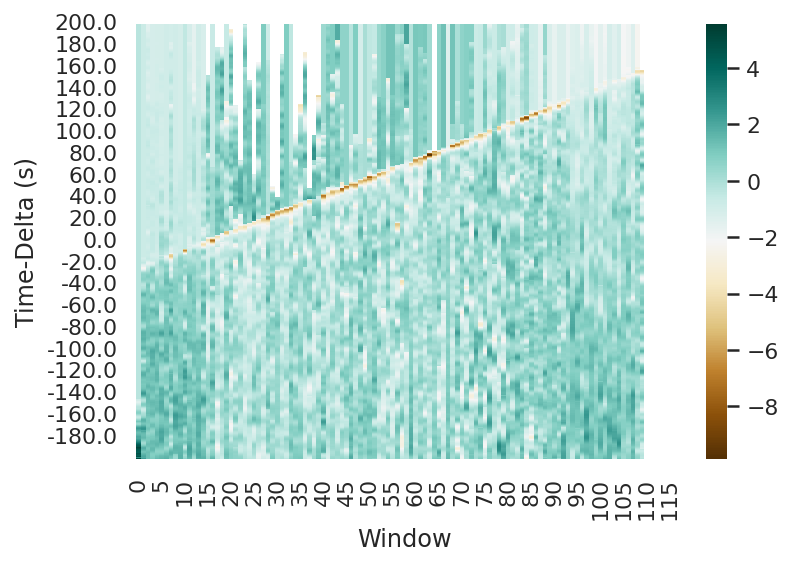

In [31]:
# spectrogram_df = pd.DataFrame(spectrogram.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/spectrogram.shape[1]))
spectrogram_mean_batched_df_normed = spectrogram_mean_batched_df.apply(
    lambda x: (x-spectrogram_mean_batched_df.mean(axis=0))/spectrogram_mean_batched_df.std(axis=0), axis=1)

ax = sns.heatmap(spectrogram_mean_batched_df_normed, linewidth=0.0, cmap="BrBG")
ax.set_xlabel("Window")
ax.set_ylabel("Time-Delta (s)")
n_yticks = 10
ax.set_yticks(np.arange(0, len(spectrogram_mean_batched_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

plt.show()

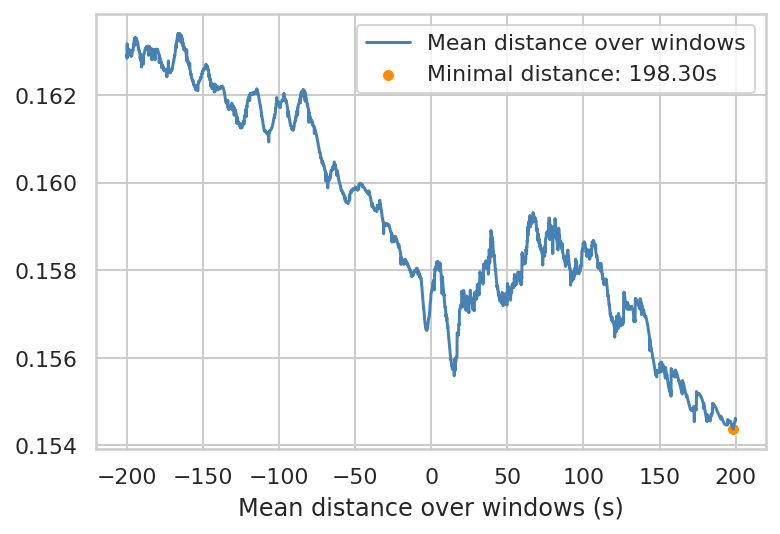

In [32]:
spectrogram_mean_df = spectrogram_mean_batched_df[spectrogram_mean_batched_df < spectrogram_mean_batched_df.max()].mean(axis=1)

sns.lineplot(data=spectrogram_mean_df,color="steelblue", label="Mean distance over windows")
sns.scatterplot(x=[spectrogram_mean_df.index[spectrogram_mean_df.argmin()]], y=[spectrogram_mean_df.iloc[spectrogram_mean_df.argmin()]], 
                color="darkorange", label=f"Minimal distance: {spectrogram_mean_df.index[spectrogram_mean_df.argmin()]:.2f}s")
plt.xlabel("Time-Delta (s)")
plt.xlabel("Mean distance over windows (s)")
plt.legend(loc="upper right")
plt.show()

## Iterative Synchronisation

In [33]:
def synchronize_file(file_ref, file_sig, td_min=-60, td_max=60, td_mid=30, 
                     sparse_factor=1, window_len=50.0, sliding_len=25.0, bandwidth=30.0, sps_adaption_factor=1, 
                     dist_max=None, regulate_paddings=True, dist_padding=None, 
                     parallelize=True, verbose=0):
    # assert integer input types
    assert isinstance(td_min, int)
    assert isinstance(td_max, int)
    assert isinstance(td_mid, int)
    assert isinstance(sparse_factor, int)
    
    file_sig_orig = file_sig.copy()
    if isinstance(file_sig, np.ndarray):
        print(f"\n\n####################### Synching file #######################")
        savedir = SYNC_PATH + os.sep + "default"
    else:
        print(f"\n\n####################### Synching {file_sig} #######################")  
        # create a file-wise savedir or empty it if existing
        savedir = SYNC_PATH + os.sep + file_sig.split(os.sep)[-1].replace(".csv", "")
    if os.path.exists(savedir):
        for file in os.listdir(savedir):
            if os.path.isfile(savedir+os.sep+file):
                os.remove(savedir+os.sep+file)
    else:
        os.mkdir(savedir)

    
    # Synchronisation in a loop, MAX_N_WIN_SYNCS or until the MAE is below MAE_THRESHOLD
    for n_win_sync in range(1, 1+MAX_N_WIN_SYNCS):
        # as file_ref_orig, file_sig_orig are arrays and not paths to files, the scaling must be performed here
        if isinstance(file_ref, np.ndarray):
            assert isinstance(file_sig_orig, np.ndarray)  # both must be either paths or arrays
            file_sig = sps_adaption_factor * file_sig_orig
            
        sps_adaption_factor, td_hat_, td_hat_median, df_results, spectrogram, rmse, mae = window_sync(
            file_ref, file_sig, td_min=td_min, td_max=td_max, sparse_factor=sparse_factor, 
            window_len=n_win_sync*window_len, sliding_len=n_win_sync*sliding_len, bandwidth=bandwidth/n_win_sync, 
            sps_adaption_factor=sps_adaption_factor, sps=SAMPLE_RATE_DT,
            dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding, 
            parallelize=parallelize, verbose=verbose, save_fig=savedir+os.sep+f"round-{n_win_sync}_timedelta.png")
        print(f"  -> Round {n_win_sync}: Found the optimal time-delta at {td_hat_:.6f}s with sps={sps_adaption_factor:.6f}Hz, RMSE={rmse:.6f}, MAE={mae:.6f}\n")
        
        if mae < MAE_THRESHOLD:
            if verbose >= 2:
                print(f"Early breaking because the MAE is below {MAE_THRESHOLD:.2f}.")
            break
     
    print(f"Resulting time-shift: {td_hat_:.6f}s and sps={sps_adaption_factor:.6f}Hz, RMSE={rmse:.6f}, MAE={mae:.6f}\n")
    
#     # Double-Check on all data
#     print("Check on full signal with skaling:")
#     arr_ref = load_file(file_ref, sps_adaption_factor=1.0, filter_large_dist=FILTER_LARGE_DIST)
#     arr_sig = load_file(file_sig, sps_adaption_factor=sps_adaption_factor, filter_large_dist=FILTER_LARGE_DIST)
    
#     # Broad search
#     df_nearest_1 = pd.DataFrame(nearest_advocate(arr_ref, arr_sig, td_min=td_min, td_max=td_max, 
#                                                          sparse_factor=1, sps=SAMPLE_RATE_DT, 
#                                                          dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding), 
#                                 columns=["time-delta", "distance"])
#     sns.lineplot(x=df_nearest_1["time-delta"], y=df_nearest_1["distance"], color="steelblue")
#     td_hat = df_nearest_1.loc[np.argmin(df_nearest_1["distance"])]["time-delta"]
#     plt.vlines(x=td_hat, ymin=0.9*df_nearest_1["distance"].min(), ymax=1.1*df_nearest_1["distance"].max(), color="black")
#     plt.hlines(y=df_nearest_1["distance"].min(), xmin=td_min, xmax=td_max, color="black")
#     plt.savefig(savedir+os.sep+"min_dgh_broad.png"); plt.cla()
#     df_away = df_nearest_1.loc[np.abs(df_nearest_1["time-delta"]-td_hat)>td_mid]
#     print(f"Broad search: Minimum at {td_hat:.6f}s with distance {df_nearest_1['distance'].min():.6f}. " + 
#           f"Other are {df_away['distance'].min():.6f}, this makes a difference of {df_away['distance'].min()-df_nearest_1['distance'].min():.6f}")
    
#     # Mid search
#     df_nearest_2 = pd.DataFrame(nearest_advocate(arr_ref, arr_sig, td_min=td_hat-td_mid, td_max=td_hat+td_mid, 
#                                                          sparse_factor=1, sps=10*SAMPLE_RATE_DT, 
#                                                          dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding), 
#                                 columns=["time-delta", "distance"])
#     sns.lineplot(x=df_nearest_2["time-delta"], y=df_nearest_2["distance"], color="steelblue")
#     td_hat = df_nearest_2.loc[np.argmin(df_nearest_2["distance"])]["time-delta"]
#     plt.vlines(x=td_hat, ymin=0.9*df_nearest_2["distance"].min(), ymax=1.1*df_nearest_2["distance"].max(), color="black")
#     print(f"Mid search: Minimum at {td_hat:.6f} s with distance {df_nearest_2['distance'].min():.6f}.")
#     plt.savefig(savedir+os.sep+"min_dgh-mid.png"); plt.cla()
    
#     # Narrow plot
#     sns.lineplot(x=df_nearest_2["time-delta"], y=df_nearest_2["distance"], color="steelblue")
#     td_hat = df_nearest_2.loc[np.argmin(df_nearest_2["distance"])]["time-delta"]
#     plt.vlines(x=td_hat, ymin=0.9*df_nearest_2["distance"].min(), ymax=1.1*df_nearest_2["distance"].max(), color="black")
#     plt.xlim(td_hat-5, td_hat+5)
#     plt.savefig(savedir+os.sep+"min_dgh-narrow.png"); plt.cla()
#     print(f"The timestamps of the signal should be subtracted by {td_hat:.6f}s.")
    
#     # Eigentliche Korrektur
#     print("\nCorrection:")
#     arr_sig = load_file(file_sig, sps_adaption_factor=sps_adaption_factor, filter_large_dist=FILTER_LARGE_DIST)
#     arr_sig = arr_sig - td_hat_
#     pd.DataFrame({"timestamp": arr_sig}).to_csv(
#         os.path.join(SYNC_PATH, file_sig.split(os.sep)[-1].replace(".csv", SYNCED_POSTFIX+".csv")), 
#         index=False)
#     # check result
#     df_nearest_1 = pd.DataFrame(sparse_search_time_delta(arr_ref, arr_sig, td_min=-td_mid, td_max=td_mid, 
#                                                          sparse_factor=1, sps=2*SAMPLE_RATE_DT, 
#                                                          dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding), 
#                                 columns=["time-delta", "distance"])
#     sns.lineplot(x=df_nearest_1["time-delta"], y=df_nearest_1["distance"], color="steelblue")
#     td_hat = df_nearest_1.loc[np.argmin(df_nearest_1["distance"])]["time-delta"]
#     plt.vlines(x=td_hat, ymin=0.9*df_nearest_1["distance"].min(), ymax=1.1*df_nearest_1["distance"].max(), color="black")
#     plt.vlines(x=0.0, ymin=0.9*df_nearest_1["distance"].min(), ymax=1.1*df_nearest_1["distance"].max(), color="firebrick")
#     plt.hlines(y=df_nearest_1["distance"].min(), xmin=-td_mid, xmax=td_mid, color="black")
#     plt.xlim(-td_mid, td_mid)
#     print(f"Minimum was found at {td_hat:.4f} s, it should be at 0.0s.")
#     plt.savefig(savedir+os.sep+"min_dgh-corrected.png"); plt.cla()

#     # Teste die Überlagerung
#     arr_sig = pd.read_csv(os.path.join(SYNC_PATH, file_sig.split(os.sep)[-1].replace(".csv", SYNCED_POSTFIX+".csv"))
#                          ).values.reshape(-1)
#     xvals = np.arange(int(arr_sig.min()), int(arr_sig.max()), 0.1)
#     df = pd.DataFrame({"time": xvals})
#     df["Sig-IBI"] = np.interp(xvals, arr_sig[1:], np.diff(arr_sig))
#     df["Ref-IBI"] = np.interp(xvals, arr_ref[1:], np.diff(arr_ref))
    
#     n_comparisions = 8
#     fig, axes = plt.subplots(n_comparisions, figsize=(8,17))
#     fig.suptitle('Random windows with both IBIs')
#     for ax in axes:
#         slice_idx = np.round(np.random.randint(0, df.shape[0]-1000), -1)
#         ax.plot(df["time"].loc[slice_idx:slice_idx+100].values, df["Ref-IBI"].loc[slice_idx:slice_idx+100].values,
#                label="Ref-IBI")
#         ax.plot(df["time"].loc[slice_idx:slice_idx+100].values, df["Sig-IBI"].loc[slice_idx:slice_idx+100].values,
#                label="Sig-IBI")
#     axes[0].legend()
#     plt.savefig(savedir+os.sep+"comparison.png"); plt.cla()
#     plt.close();
    
#     print(f"\nThe timeshift of the measurement '{file_sig.split(os.sep)[-1]}' is {td_hat_:.6f}s.")
#     print(f"The real samplerate is scaled by {sps_adaption_factor:.6f}.")

    return sps_adaption_factor, td_hat_, td_hat_median, df_results, spectrogram, rmse, mae



####################### Synching file #######################


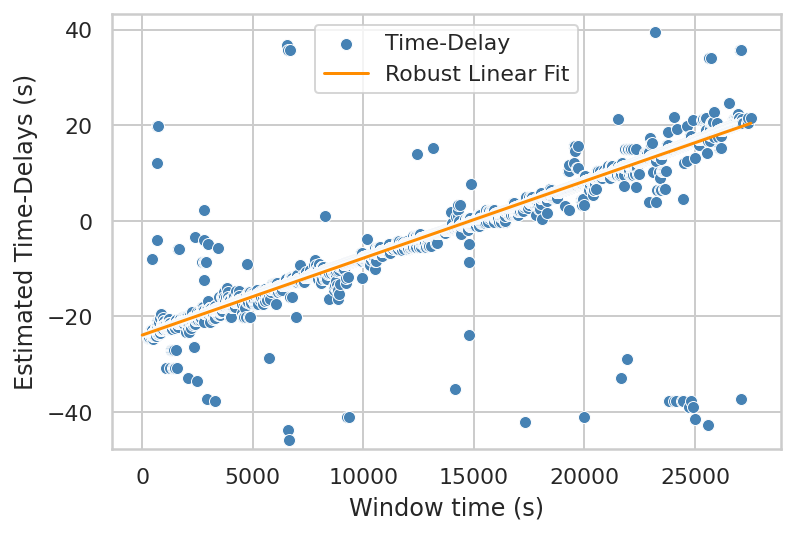


  -> Round 1: Found the optimal time-delta at -23.890729s with sps=0.993399Hz, RMSE=30.156924, MAE=6.680624



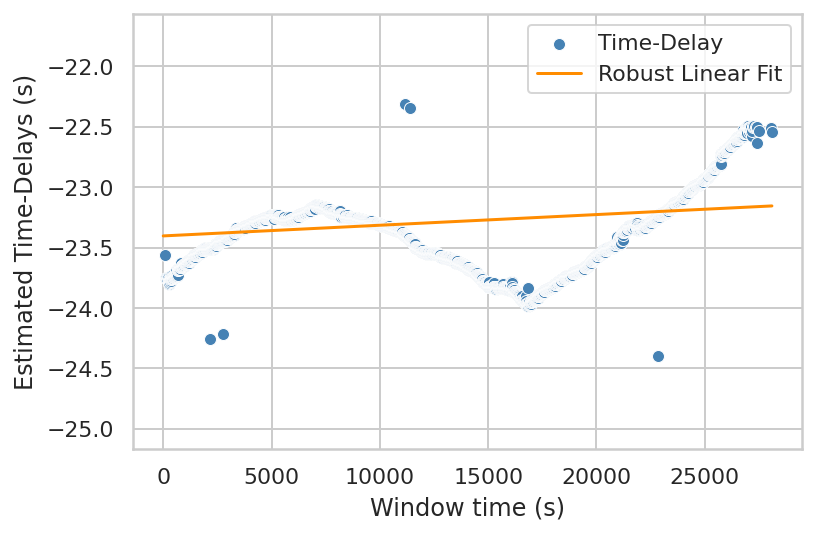


  -> Round 2: Found the optimal time-delta at -23.403332s with sps=0.993390Hz, RMSE=16.232483, MAE=1.847056



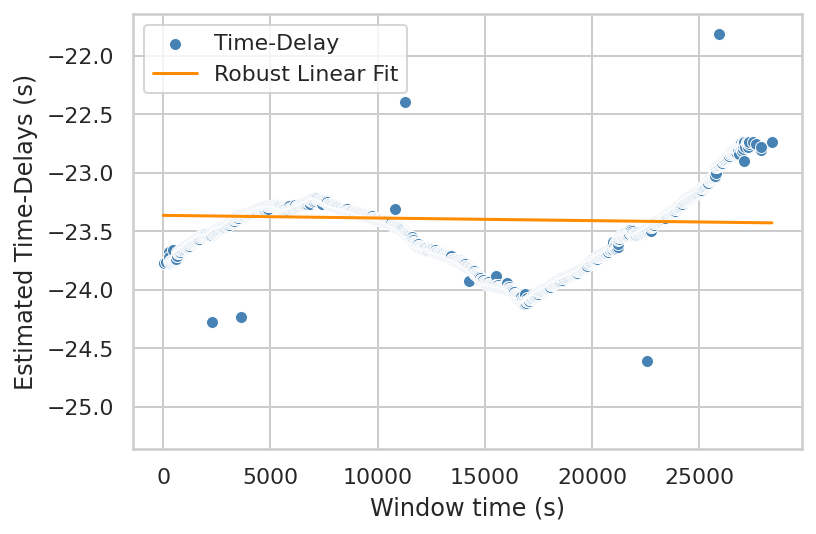


  -> Round 3: Found the optimal time-delta at -23.364927s with sps=0.993392Hz, RMSE=14.211505, MAE=1.484119



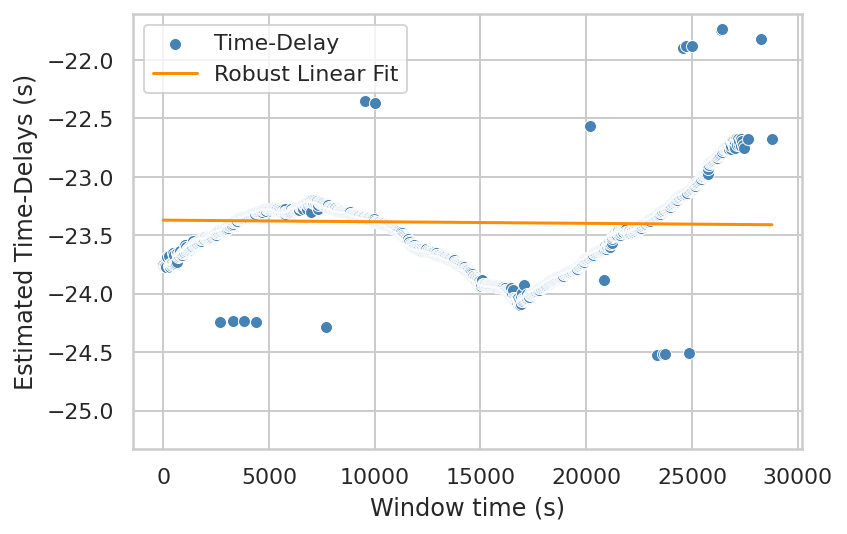


  -> Round 4: Found the optimal time-delta at -23.369773s with sps=0.993394Hz, RMSE=12.949552, MAE=1.257016



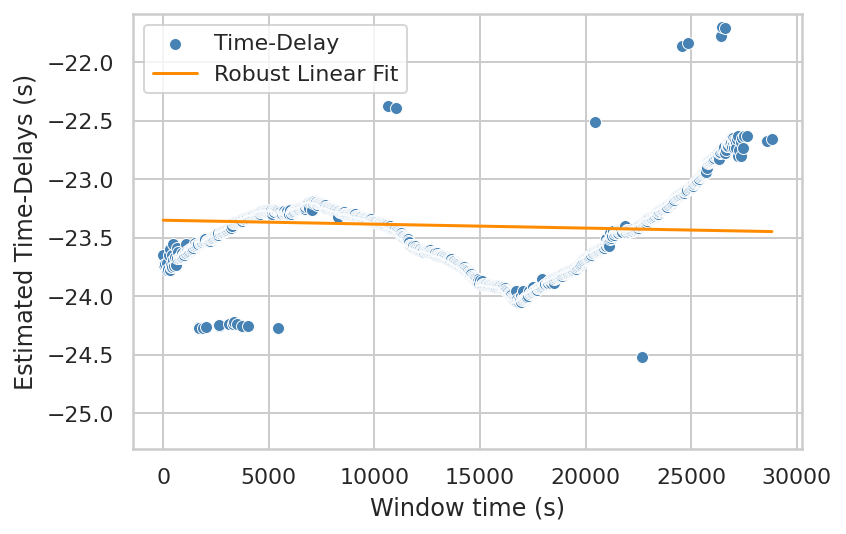


  -> Round 5: Found the optimal time-delta at -23.350425s with sps=0.993397Hz, RMSE=11.894623, MAE=1.083471



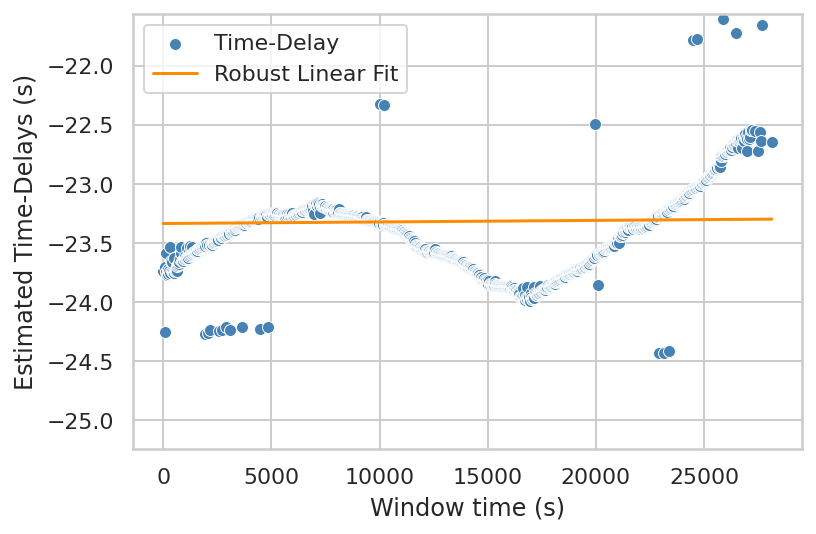


  -> Round 6: Found the optimal time-delta at -23.335218s with sps=0.993396Hz, RMSE=5.838217, MAE=0.478597

Resulting time-shift: -23.335218s and sps=0.993396Hz, RMSE=5.838217, MAE=0.478597



In [34]:
# print(offbody_ibi_files[file_idx])
sps_adaption_factor, td_hat, td_hat_median, df_results, spectrogram, rmse, mae = synchronize_file(
    file_ref=arr_ref, file_sig=arr_sig,
    td_min=TD_MIN, td_max=TD_MAX, td_mid=TD_MID, 
    sparse_factor=1, sps_adaption_factor=SPS_ADAPTATION_FACTOR, 
    window_len=WINDOW_LENGTH, sliding_len=SLIDING_LENGTH, bandwidth=BANDWIDTH,
    dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX, 
    verbose=1.5)